<a href="https://colab.research.google.com/github/Nega0619/Aiffel_Submitted_Exploration_nodes/blob/main/Going_Deeper(NLP)_06_Investigate_the_biases_in_the_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd /content/drive/MyDrive/GoingDeeper(NLP)

/content/drive/MyDrive/GoingDeeper(NLP)


In [3]:
pwd

'/content/drive/MyDrive/GoingDeeper(NLP)'

In [4]:
# WEAT 구현하기


이번 노트북에서는 프로젝트를 진행해보았습니다.

목차
- WEAT 구현하기
- Pretrained 된 word embedding 모델에 weat 적용
- 직접 Word Embedding을 만들고 WEAT에 적용해보기
- 모든 장르 간 편향성 측정해보기

# 1. WEAT Score 구현하기


WEAT Score란?
 
 s(w, A, B)s(w,A,B)가 의미하는 것은 target에 있는 단어 ww가 두 attribute 셋 A, B에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지를 측정합니다. 

 WEAT정의는 다음과 같습니다.



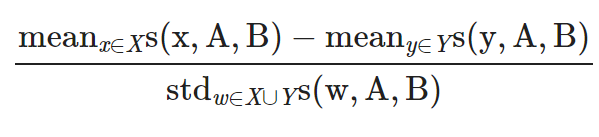

위 값은 아래 두개의 식을 통하여 실현됩니다.

- cosine similarity cos(θ)

벡터 i와 j가 있을 때, cos(벡터i, 벡터j)는 벡터 i와 벡터 j의 cosine similarity를 의미한다.

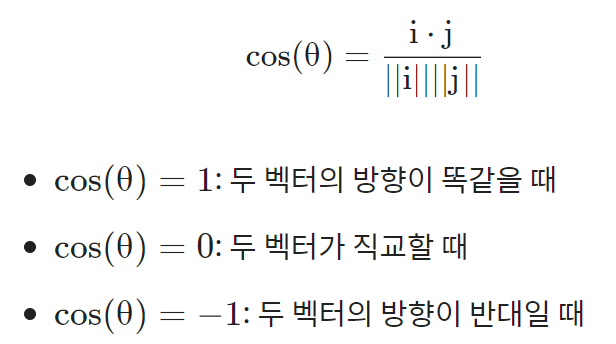

- s(w,A,B)
target에 있는 단어 w가 두 Atrribute 세트 A, B에 속한 단어들과의 유사도 평균값이 얼마나 차이 나는지를 측정

-2~2 사이 값을 가짐

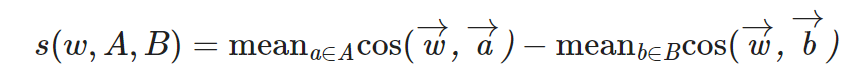

- 분자 식 : target X, Y에 속하는 단어 x,y들이 개념 축 A-B에 대해 가지는 편향성을 각각 평균 내서 뺀 차이

= X에 속하는 단어들과 Y에 속하는 단어들이 개념축에 대해 가지는 편향성의 정도가 뚜렷이 차이날 수록 WEAT Score식의 분자 값의 절대값은 커짐



- 분모 식 : 분자 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준편차(std)로 normalize한 값이 최종 WEAT Score가 됩니다.


In [5]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

print("슝~")

슝~


 두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의하였습니다.

 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기가 같아야합니다.

 단어들의 임베딩결과를 임의로 정해주고 WEAT Score를 계산하는 코드를 구현해보았습니다.

In [6]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

print("슝~")

슝~


In [7]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [8]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


s('장미', A, B) 를 계산해보도록 하겠습니다.



In [9]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

print(s(target_X['장미'], A, B))

0.6457646122337399


WEAT Score 값이 양수이므로 Target X에 있는 '장미'라는 단어는 attribute_B('불쾌')보다 attribute_A('유쾌')와 더 가깝다는 것을 알 수 있습니다.

다른 예시 거미도 확인해보겠습니다.

In [10]:
print(s(target_Y['거미'], A, B))

-0.794002342033094


In [11]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


다음은 TARGET X, Y와 ATTRIBUTE A, B 사이의 평균값이 어떻게 될지 살펴보았습니다.

In [12]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


In [13]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


WEAT Score를 코드로 구현

In [14]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.932


PCA를 통해 5차원이었던 벡터를 2차원으로 줄여 그려봄

파란색점(A)와 하늘색 점 (X)가 가깝고, 빨간색 점 (B)와 분홍색 점(Y)가 가깝게 표현된 것을 확인할 수있습니다.

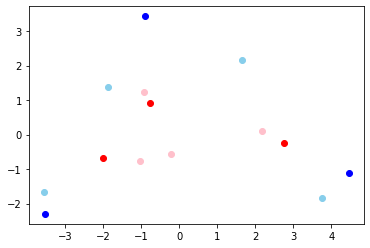

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

# 2. Pretrained 된 word embedding 모델에 weat 적용

In [16]:
import os

data_dir = '/content/drive/MyDrive/GoingDeeper(NLP)/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [17]:
print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
# print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [18]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [19]:
# happy와 유사한 단어 확인
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890128135681),
 ('pleased', 0.6632171273231506),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049768447876),
 ('satisfied', 0.6437950134277344),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247666478157043)]

In [20]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662652492523193),
 ('familiy', 0.6517066955566406),
 ('families', 0.6252894401550293),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.576207160949707),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [21]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597154140472412),
 ('kindergarten', 0.6529810428619385),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997899055481),
 ('teacher', 0.63824063539505),
 ('students', 0.6301523447036743),
 ('classroom', 0.6281620860099792),
 ('Schools', 0.6172096133232117)]

In [22]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

### WEAT 테스트

target_x : 인스턴트 식품

target_y : 비 인스턴트 식품

attribute_a : 인스턴트를 의미하는 단어들로

attribute_b : 인스턴트를 의미하지 않는 단어들로 구성

예상 결과 : tartget_x와 attribute_a는 가깝고, target_y와 attribute_y는 가깝다고 나온다.


In [23]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

좋은 결과가 나왔습니다. 이 경우, 모델이 편향 되었다고 해석되기 보다, 단어의 의미를 잘 파악했다고 볼 수 있습니다. 

다른 여러 테스트도 진행해보았습니다.

In [24]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

0에 가까운 결과를 보였습니다.

이는 임베딩 모델이 판단하기에 어느것 끼리 가깝다고 말할 수 없는 경우 이렇게 나옵니다.

In [25]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료


# 3. 직접 Word Embedding을 만들고 WEAT에 적용해보기

미니목차
---
- 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
- 추출된 결과로 embedding model 만들기
- TF/IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
- embedding model과 단어 셋으로 WEAT score 구해보기

## 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기


In [26]:
cd weat

/content/drive/MyDrive/GoingDeeper(NLP)/weat


In [27]:
!ls

GoogleNews-vectors-negative300.bin     synopsis_gen.txt
GoogleNews-vectors-negative300.bin.gz  synopsis_historical.txt
synopsis_action.txt		       synopsis_horror.txt
synopsis_adult.txt		       synopsis_musical.txt
synopsis_adventure.txt		       synopsis_mystery.txt
synopsis_animation.txt		       synopsis_romance.txt
synopsis_art.txt		       synopsis_SF.txt
synopsis_comedy.txt		       synopsis_show.txt
synopsis_crime.txt		       synopsis_thriller.txt
synopsis_documentary.txt	       synopsis.txt
synopsis_drama.txt		       synopsis_war.txt
synopsis_etc.txt		       synopsis_western.txt
synopsis_family.txt		       synopsis.zip
synopsis_fantasy.txt		       synopsis.zip.1


In [28]:
! rm *.zip.*

In [29]:
!ls

GoogleNews-vectors-negative300.bin     synopsis_gen.txt
GoogleNews-vectors-negative300.bin.gz  synopsis_historical.txt
synopsis_action.txt		       synopsis_horror.txt
synopsis_adult.txt		       synopsis_musical.txt
synopsis_adventure.txt		       synopsis_mystery.txt
synopsis_animation.txt		       synopsis_romance.txt
synopsis_art.txt		       synopsis_SF.txt
synopsis_comedy.txt		       synopsis_show.txt
synopsis_crime.txt		       synopsis_thriller.txt
synopsis_documentary.txt	       synopsis.txt
synopsis_drama.txt		       synopsis_war.txt
synopsis_etc.txt		       synopsis_western.txt
synopsis_family.txt		       synopsis.zip
synopsis_fantasy.txt


In [30]:
! wget https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip

--2022-04-09 04:19:29--  https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18399462 (18M) [application/x-zip-compressed]
Saving to: ‘synopsis.zip.1’

synopsis.zip.1      100%[===================>]  17.55M  4.30MB/s    in 5.9s    

2022-04-09 04:19:36 (2.99 MB/s) - ‘synopsis.zip.1’ saved [18399462/18399462]



In [31]:
import os

file_path = '/content/drive/MyDrive/GoingDeeper(NLP)/weat/'

with open('/content/drive/MyDrive/GoingDeeper(NLP)/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [32]:
!  pip install konlpy

In [33]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(file_path + 'synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [34]:
print(len(tokenized))

71156


### 2. 추출된 결과로 embedding model 만들기

In [35]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
# model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
# model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('작품', 0.902980625629425),
 ('다큐멘터리', 0.8460893630981445),
 ('드라마', 0.8415271639823914),
 ('영화로', 0.8130561113357544),
 ('형식', 0.8045082688331604),
 ('주제', 0.802771806716919),
 ('코미디', 0.8009828329086304),
 ('감동', 0.7966427206993103),
 ('영상', 0.7911012172698975),
 ('영감', 0.7859139442443848)]

확인작업

In [36]:
model.wv.most_similar(positive=['사랑'])

[('아르튬', 0.740328311920166),
 ('정일', 0.708454966545105),
 ('진심', 0.7055668830871582),
 ('만남', 0.7045221328735352),
 ('행복', 0.7023637294769287),
 ('운명', 0.6991608142852783),
 ('첫사랑', 0.692527174949646),
 ('애정', 0.6919513940811157),
 ('친타', 0.687328040599823),
 ('우정', 0.6866573095321655)]

In [37]:
model.wv.most_similar(positive=['연극'])

[('시나리오', 0.9191700220108032),
 ('영감', 0.9098044037818909),
 ('영화감독', 0.8980830907821655),
 ('출연', 0.8952521085739136),
 ('캐스팅', 0.8946771025657654),
 ('각색', 0.8867373466491699),
 ('배우', 0.8845324516296387),
 ('예술가', 0.8814601898193359),
 ('감성', 0.877076268196106),
 ('데뷔', 0.8764669895172119)]

### 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

In [38]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(file_path + file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [39]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [40]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [41]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [43]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(target_art)

In [ ]:
print(target_gen)

In [ ]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

print("슝~")

In [47]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

# 4. embedding model과 단어 셋으로 WEAT score 구해보기

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

# 코랩에서 sns 그래프에서 한글을 사용하기 위해 해결한 코드

https://teddylee777.github.io/colab/colab-korean

In [53]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

# 4. 모든 장르 간 편향성 측정해보기

In [55]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
3.6.0
1.0.2
0.11.2


# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기


In [56]:
!pwd

/content/drive/MyDrive/GoingDeeper(NLP)/weat


In [57]:
!ls

GoogleNews-vectors-negative300.bin     synopsis_gen.txt
GoogleNews-vectors-negative300.bin.gz  synopsis_historical.txt
synopsis_action.txt		       synopsis_horror.txt
synopsis_adult.txt		       synopsis_musical.txt
synopsis_adventure.txt		       synopsis_mystery.txt
synopsis_animation.txt		       synopsis_romance.txt
synopsis_art.txt		       synopsis_SF.txt
synopsis_comedy.txt		       synopsis_show.txt
synopsis_crime.txt		       synopsis_thriller.txt
synopsis_documentary.txt	       synopsis.txt
synopsis_drama.txt		       synopsis_war.txt
synopsis_etc.txt		       synopsis_western.txt
synopsis_family.txt		       synopsis.zip
synopsis_fantasy.txt		       synopsis.zip.1


In [58]:
import glob, os

for file in glob.glob('*.txt'):
  print(file)
  # print(type(file))
# def get_txt_fileName(path):
#   all_files =
#   file = all_files.read()

synopsis.txt
synopsis_gen.txt
synopsis_art.txt
synopsis_action.txt
synopsis_musical.txt
synopsis_horror.txt
synopsis_thriller.txt
synopsis_western.txt
synopsis_SF.txt
synopsis_adult.txt
synopsis_adventure.txt
synopsis_comedy.txt
synopsis_historical.txt
synopsis_fantasy.txt
synopsis_war.txt
synopsis_crime.txt
synopsis_documentary.txt
synopsis_show.txt
synopsis_romance.txt
synopsis_animation.txt
synopsis_etc.txt
synopsis_mystery.txt
synopsis_drama.txt
synopsis_family.txt


In [59]:
# def read_token(file_extension):
#   for file_name in glob.glob(file_extension):
#     okt = Okt()
#     result = []
#     with open(file_path + file_name, 'r') as fread: 
#         print(file_name, '파일을 읽고 있습니다.')
#         while True:
#             line = fread.readline() 
#             if not line: break 
#             tokenlist = okt.pos(line, stem=True, norm=True) 
#             for word in tokenlist:
#                 if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
#                     result.append((word[0])) 
#     return ' '.join(result)

# print("슝~")

In [60]:
# all = read_token('synopsis.txt')

In [61]:
okt = Okt()
tokenized = []
with open(file_path + 'synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)


# STEP 2. 추출된 결과로 embedding model 만들기

In [ ]:
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

# STEP 3. target, attribute 단어 셋 만들기

- 영화 구분


  - synopsis_art.txt : 예술영화


  - synopsis_gen.txt : 일반영화(상업영화)


  - 그 외는 독립영화 등으로 분류됩니다.


- 장르 구분


  - synopsis_SF.txt: SF


  - synopsis_가족.txt: 가족


  - synopsis_공연.txt: 공연


  - synopsis_공포(호러).txt: 공포(호러)


  - synopsis_기타.txt: 기타


  - synopsis_다큐멘터리.txt: 다큐멘터리


  - synopsis_드라마.txt: 드라마


  - synopsis_멜로로맨스.txt: 멜로로맨스


  - synopsis_뮤지컬.txt: 뮤지컬


  - synopsis_미스터리.txt: 미스터리


  - synopsis_범죄.txt: 범죄


  - synopsis_사극.txt: 사극


  - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)


  - synopsis_성인물(에로).txt: 성인물(에로)


  - synopsis_스릴러.txt: 스릴러


  - synopsis_애니메이션.txt: 애니메이션


  - synopsis_액션.txt: 액션


  - synopsis_어드벤처.txt: 어드벤처


  - synopsis_전쟁.txt: 전쟁


  - synopsis_코미디.txt: 코미디


  - synopsis_판타지.txt: 판타지



In [ ]:
art = read_token(art_txt)
gen = read_token(gen_txt)

## TF-IDF 판단해보기

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

In [ ]:
# 중복 제거
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
print(target_art)


In [ ]:
print(target_gen)


In [ ]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [ ]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

# STEP 4. WEAT score 계산과 시각화

In [ ]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))


def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X - mean_Y) / std_dev

- attribute A, attribute B : 영화 장르를 유연하게 선택
- target X : art, 예술영화
- target Y : gen, 일반영화

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 0.8 or matrix[i][j] < -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

## 시각화

In [ ]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt;  

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax;